# Flower Recognition using Pre-trained model

## Importing dataset from Kaggle

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d alxmamaev/flowers-recognition

In [4]:
# from zipfile import ZipFile
# file_name = "flowers-recognition.zip"

# with ZipFile(file_name,"r") as zip:
# 	zip.extractall()
# 	print("Done")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import os

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Sample images

In [6]:
flowers_dir = '/content/flowers/flowers'
flower_labels = sorted(os.listdir(flowers_dir))
flower_labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

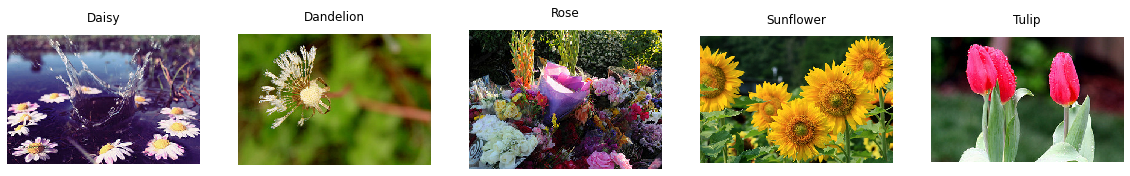

In [7]:
sample_images = {
    'daisy':'/content/flowers/flowers/daisy/10172379554_b296050f82_n.jpg',
    'dandelion': '/content/flowers/flowers/dandelion/10200780773_c6051a7d71_n.jpg',
    'rose': '/content/flowers/flowers/rose/10894627425_ec76bbc757_n.jpg',
    'sunflower': '/content/flowers/flowers/sunflower/1008566138_6927679c8a.jpg',
    'tulip': '/content/flowers/flowers/tulip/100930342_92e8746431_n.jpg'
}

fig,ax = plt.subplots(ncols=5,figsize=(20,4))
for index,flower in enumerate(sample_images):
    ax[index].set_title(flower.capitalize())
    ax[index].axis('off')
    flower_img = np.array(load_img(sample_images[flower]))
    ax[index].matshow(flower_img)

## Data Preprocessing

* Iterate through all images
* Resize image into (299,299,3) since the model expects this input shape
* Convert image into numpy array
* Append features in X and labels in y

In [8]:
X = []
y = []
flowers_dir_path_object = pathlib.Path(flowers_dir)
for label_number,flower in enumerate(flower_labels):
    # get all paths of images inside flower subdirectory
    flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    for image in flower_images_paths:
        # load and resize image
        resized_image = load_img(str(image),target_size=(299,299))
        # append features in X and labels in y
        X.append(np.array(resized_image))
        y.append(label_number)

In [9]:
X = np.array(X)
y = np.array(y)

print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (4323, 299, 299, 3)
y shape: (4323,)


## Model Building

* Train test split
* Fine-tuning pre-trained model
* Model evaluation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (3242, 299, 299, 3)
X test shape: (1081, 299, 299, 3)


In [11]:
img_height = 299
img_width = 299

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",trainable=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 21,934,245
Trainable params: 131,461
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
history = model.fit(X_train,y_train,batch_size=64,validation_split=0.2,epochs=5)

Epoch 1/5
41/41 [==============================] - 22s 344ms/step - loss: 0.8745 - accuracy: 0.6740 - val_loss: 0.4591 - val_accuracy: 0.8428
Epoch 2/5
41/41 [==============================] - 11s 278ms/step - loss: 0.3564 - accuracy: 0.8824 - val_loss: 0.3893 - val_accuracy: 0.8675
Epoch 3/5
41/41 [==============================] - 12s 282ms/step - loss: 0.2966 - accuracy: 0.9076 - val_loss: 0.3625 - val_accuracy: 0.8783
Epoch 4/5
41/41 [==============================] - 12s 287ms/step - loss: 0.2242 - accuracy: 0.9230 - val_loss: 0.3588 - val_accuracy: 0.8752
Epoch 5/5
41/41 [==============================] - 12s 291ms/step - loss: 0.1747 - accuracy: 0.9502 - val_loss: 0.3938 - val_accuracy: 0.8629


In [13]:
model.evaluate(X_test,y_test)

34/34 [==============================] - 6s 148ms/step - loss: 0.3547 - accuracy: 0.8770


[0.35466209053993225, 0.8769657611846924]

In [14]:
predictions = model.predict(X_test)
max_predictions = [np.argmax(value) for value in predictions]
max_predictions[:5]

[3, 4, 4, 1, 0]

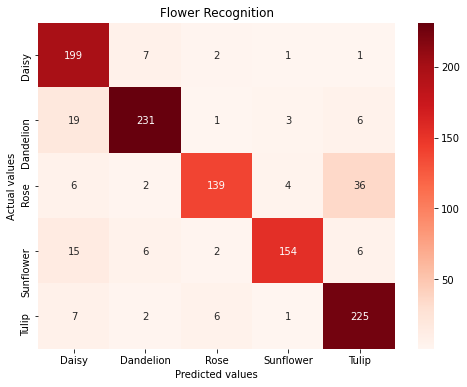

In [15]:
confusion_matrix_result = confusion_matrix(y_test,max_predictions)

labels = ['Daisy','Dandelion','Rose','Sunflower','Tulip']
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Reds',fmt='.0f',xticklabels=labels,yticklabels=labels)
plt.title('Flower Recognition')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [16]:
classification_report_result = classification_report(y_test,max_predictions)
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       210
           1       0.93      0.89      0.91       260
           2       0.93      0.74      0.82       187
           3       0.94      0.84      0.89       183
           4       0.82      0.93      0.87       241

    accuracy                           0.88      1081
   macro avg       0.89      0.87      0.87      1081
weighted avg       0.88      0.88      0.88      1081



## Saving the model

In [17]:
model.save('flower_recognition_pretrained.h5')

## Load saved model and predict new images

In [18]:
# Loading saved model
loaded_model = tf.keras.models.load_model('flower_recognition_pretrained.h5',
                                          custom_objects={'KerasLayer':hub.KerasLayer}
                                          )

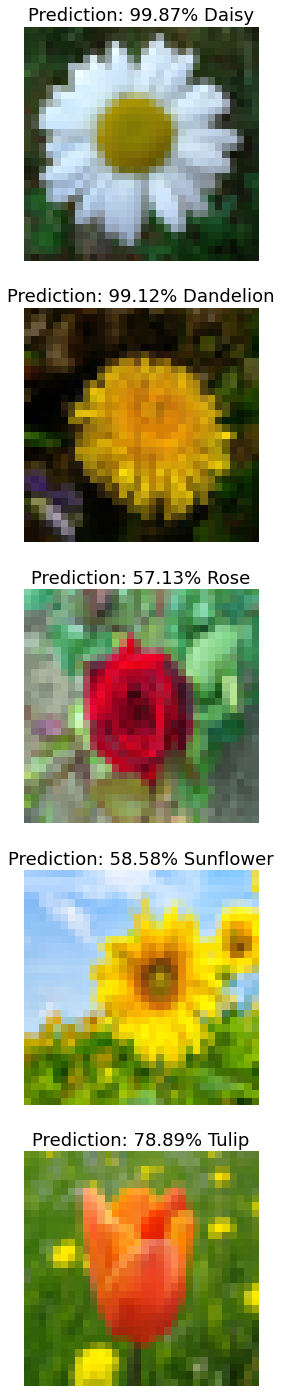

In [19]:
test_images = {
    'daisy':'/content/daisy.jpg',
    'dandelion': '/content/dandelion.jpg',
    'rose': '/content/rose.jpg',
    'sunflower': '/content/sunflower.jpg',
    'tulip': '/content/tulip.jpeg'
}

new_X_test = []

# Resizing test images and converting to numpy array
# Stores array in new_X_test
for flower in test_images.values():
    resized_image = load_img(flower,target_size=(299,299))
    new_X_test.append(np.array(resized_image))

# predict test images with loaded model
test_predictions = loaded_model.predict(np.array(new_X_test))

labels = ['Daisy','Dandelion','Rose','Sunflower','Tulip']
fig,ax = plt.subplots(nrows=5,figsize=(5,25),sharey=True)

for index,path in enumerate(test_images.values()):
  # getting the highest percentage
  percentage = round(max(test_predictions[index])*100,2)
  # getting the flower with highest percentage
  label = labels[np.argmax(test_predictions[index])]
  # displaying predicted flowers with percentage and labels
  ax[index].set_title('Prediction: {}% {}'.format(percentage,label),fontsize=18)
  img = tf.keras.preprocessing.image.load_img(path)
  img_resized = np.array(img.resize((32,32)))
  ax[index].imshow(img_resized)
  ax[index].axis('off')